TODO:
* znaleźć takie cząsteczki, dla których wszystkie metody miały MCC=0 (lub mniejsze niż jakiś próg). Potraktować je jako outliers.

In [1]:
import pandas as pd

In [2]:
!ls /data/2d-rna/validation-all-non0/results.rpt

/data/2d-rna/validation-all-non0/results.rpt


In [3]:
! ls /data/2d-rna

1.txt	       fasta1000		  seq500
2.txt	       fasta500			  test
7z2107	       fasta600			  tmp
all	       fasta600-1800		  to_remove.txt
all500.fasta   fasta-cifs		  u-cifs
all.txt        ipknot			  validation-all
a.txt	       predictions-bpseqs	  validation-all-non0
b.txt	       predictions-raw		  validation-canon
canon.txt      predictions-rna-structure  validation-canon-non0
cifs	       pseudoknots-bpseqs	  validation-noncanon
cifs-awk       remover.sh		  validation-noncanon-non0
cifs-mini      rnapdbee-cifs		  validation-pseudoknots
clean-non0.sh  rna-structure-bpseqs	  validation-results
dbn-cifs       rna-struct-validation
diff.py        scripts


## Load results

In [4]:
res_path = "/data/2d-rna/validation-all-non0/results.rpt"
out_path = "all"

In [5]:
import os
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [6]:
with open(res_path) as f:
    results = f.readlines()
len(results)

122716

` :/data/2d-rna/cifs$ ls | sed 's/.cif//g' | awk '{ print toupper($0) }' | sort | uniq | wc -l`<br>
`12728` tyle jest unikalnych nazw w cząsteczek ignorując wielkoś znaków

`11733` tyle jest rekordów dla narzędzi w pliku wynikowym. Brakujące mogą wynikać z niezgodności sekwencji. <br>
TODO: 
Z pipeline usunąc "^^" i puścić jeszcze raz (toupper). Nazwy plików są poprawne.

### Filter results

Common subset

In [7]:
subset_ids = {}
k=""
counter = 0
for l in results:
    l = l.split()
    if len(l) == 0:
        break
    elif len(l) ==1:
        k=l[0]
    elif l[0]!="Tool":
        method = l[0]
        res = l[1:]
        res = [float(r) for r in res]
        if method not in subset_ids:
            subset_ids[method]=[]
        subset_ids[method].append(k)
    counter += 1
print(counter)


122715


In [8]:
list(subset_ids.keys())

['contextFold',
 'contrafold',
 'e2efold',
 'mxfold',
 'mxfold2',
 'rna-state-inf',
 'spot-rna',
 'ipknot',
 'rnafold',
 'rna-structure',
 'ufold']

In [9]:
sets = []
for m in list(subset_ids.keys()):
# for m in ['mxfold', 'rnafold', 'spot-rna', 'mxfold2']:
# for m in ['spot-rna', 'ufold', 'ipknot', 'e2efold']:
    print(m, len(subset_ids[m]))
    sets.append(set(subset_ids[m]))


contextFold 10354
contrafold 10491
e2efold 9257
mxfold 10491
mxfold2 9374
rna-state-inf 10491
spot-rna 7671
ipknot 7665
rnafold 10491
rna-structure 7805
ufold 7643


In [10]:
# sets = [set(v) for v in subset_ids.values()]
common = sets[0].intersection(*sets)
print(len(common))
print(sorted(common)[:10])

7354
['100D_1_A-B', '157D_1_A-B', '165D_1_A-B', '17RA_7_A', '1A1T_1_B', '1A34_1_B-C', '1A3M_1_A-B', '1A4D_1_A-B', '1A4T_1_A', '1A51_3_A']


Na tych czasteczkach puscic pomiar czasu. Czas - wall time <br>
Wykluczyć wszystkie cząsteczki, które w targecie nie mają żadnej pary.(3 kolumna ma tylko 0 / Nie ma żadnej wartości większej niż 0)

In [11]:
not_common = [x for x in sets[0] if x not in common]
print(len(not_common))
# not_common

3000


Collect results for methods

In [12]:
pdb_id_res = {}
k=""
for l in results:
    l = l.split()
    if len(l)==0:
        pass
    elif len(l) ==1:
        k=l[0]
        if k in common:
            pdb_id_res[k]={}
    elif l[0]!="Tool":
        method = l[0]
        res = l[1:]
        res = [float(r) for r in res]
        if k in common:
            pdb_id_res[k][method]=res

In [13]:
met_res = {}
indeces = {}
for method in subset_ids.keys():
# for method in ['spot-rna', 'e2efold', 'ipknot', 'ufold']: # for pseudoknots
    if method not in met_res:
        met_res[method] = []
        indeces[method] = []
    for k_id in pdb_id_res.keys():
        met_res[method].append(pdb_id_res[k_id][method])
        indeces[method].append(k_id)
for m, v in met_res.items():
    print(m, len(v))

contextFold 7354
contrafold 7354
e2efold 7354
mxfold 7354
mxfold2 7354
rna-state-inf 7354
spot-rna 7354
ipknot 7354
rnafold 7354
rna-structure 7354
ufold 7354


In [14]:
df = pd.DataFrame(met_res['spot-rna'], columns=['PPV', 'TPR', 'F1', 'INF-MCC'], index=indeces['spot-rna'])
df.loc[df['INF-MCC']==0].head(100).tail()
# df.head()

,PPV,TPR,F1,INF-MCC
3AGV_1_S,0.0,0.0,0.0,0.0
3AGV_1_U,0.0,0.0,0.0,0.0
3BOY_1_D,0.0,0.0,0.0,0.0
3DD2_1_B,0.0,0.0,0.0,0.0
3DKN_1_D-E,0.0,0.0,0.0,0.0


In [15]:
cols = ['PPV', 'TPR', 'F1', 'INF-MCC']
dfs = {}
means = {}
stds = {}
for m, vals in met_res.items():
    df = pd.DataFrame(vals, columns=cols, index=indeces[m])
    df.to_csv(os.path.join(out_path, m+".csv"))
    dfs[m] = df
    print(m)
    res = df.mean().to_list()
    res = [round(r, 2) for r in res]
    res_std = df.std().to_list()
    res_std = [round(r, 2) for r in res_std]
    means[m] = res
    stds[m] = res_std

contextFold
contrafold
e2efold
mxfold
mxfold2
rna-state-inf
spot-rna
ipknot
rnafold
rna-structure
ufold


In [16]:
import matplotlib.pyplot as plt
# _= plt.hist(dfs['ufold']["INF-MCC"].values, bins=50)

In [17]:
import numpy as np
print(np.std(dfs['ufold']["INF-MCC"].values))
print(np.mean(dfs['ufold']["INF-MCC"].values))

0.25870689197032065
0.652392983410389


## Summary

In [18]:
df_means = pd.DataFrame(means.values(), columns=cols, index=means.keys())
df_means = df_means.sort_values("INF-MCC", ascending=False)
print(df_means.head(20))
df_means.to_csv(os.path.join(out_path, "means.csv"))

df_std = pd.DataFrame(stds.values(), columns=cols, index=df_means.index)
# df_std = df_std.sort_values(df_means['INF-MCC'], ascending=False)
print(df_std.head(20))
df_std.to_csv(os.path.join(out_path, "stds.csv"))

                PPV   TPR    F1  INF-MCC
spot-rna       0.61  0.85  0.70     0.71
mxfold2        0.54  0.81  0.64     0.66
ufold          0.53  0.81  0.63     0.65
contextFold    0.50  0.80  0.61     0.63
ipknot         0.46  0.72  0.55     0.57
contrafold     0.47  0.66  0.54     0.55
rnafold        0.46  0.67  0.54     0.55
mxfold         0.43  0.69  0.52     0.54
rna-state-inf  0.43  0.64  0.51     0.52
rna-structure  0.36  0.54  0.43     0.44
e2efold        0.22  0.45  0.30     0.32
                PPV   TPR    F1  INF-MCC
spot-rna       0.24  0.32  0.26     0.27
mxfold2        0.28  0.33  0.29     0.29
ufold          0.24  0.42  0.30     0.31
contextFold    0.25  0.33  0.28     0.28
ipknot         0.24  0.29  0.25     0.25
contrafold     0.26  0.34  0.29     0.29
rnafold        0.24  0.26  0.25     0.24
mxfold         0.24  0.30  0.25     0.26
rna-state-inf  0.27  0.35  0.30     0.30
rna-structure  0.27  0.36  0.30     0.30
e2efold        0.25  0.30  0.26     0.26


### Seaborn bar of means

In [20]:
names = {
'spot-rna':'SPOT-RNA', 'mxfold2':'MXfold2', 'ufold':'UFold', 'contextFold':'Contextfold', 'ipknot':'IPknot', 'contrafold':'CONTRAfold',
       'rnafold':'RNAFold', 'mxfold':'MXfold', 'rna-state-inf':'RNA State Inf.', 'rna-structure':'RNAStructure', 'e2efold':'E2efold'}

mcc_dfs = {}
for m in sorted(dfs.keys()):
    mcc_df = pd.DataFrame( dfs[m]['INF-MCC'])
    mcc_df.rename(columns={"INF-MCC":m}, inplace=True)
    mcc_dfs[m]=mcc_df

all_dfs = list(mcc_dfs.values())
x = all_dfs[0].join(all_dfs[1:])
       
m =[]
inf = []
means = []
for met in df_means.index:
    print(met)
    inf.extend(x[met].values)
    m.extend(np.full(len(x[met].values), names[met]))
    means.extend(np.full(len(x[met].values), str(round(x[met].mean(), 2))))
sns_df = pd.DataFrame({"Method":m, "INF-MCC":inf, 'Means':means})

# x.head()
sns_df.head()

spot-rna
mxfold2
ufold
contextFold
ipknot
contrafold
rnafold
mxfold
rna-state-inf
rna-structure
e2efold


,Method,INF-MCC,Means
0,SPOT-RNA,0.949,0.71
1,SPOT-RNA,0.802,0.71
2,SPOT-RNA,0.000,0.71
3,SPOT-RNA,0.943,0.71
4,SPOT-RNA,0.894,0.71


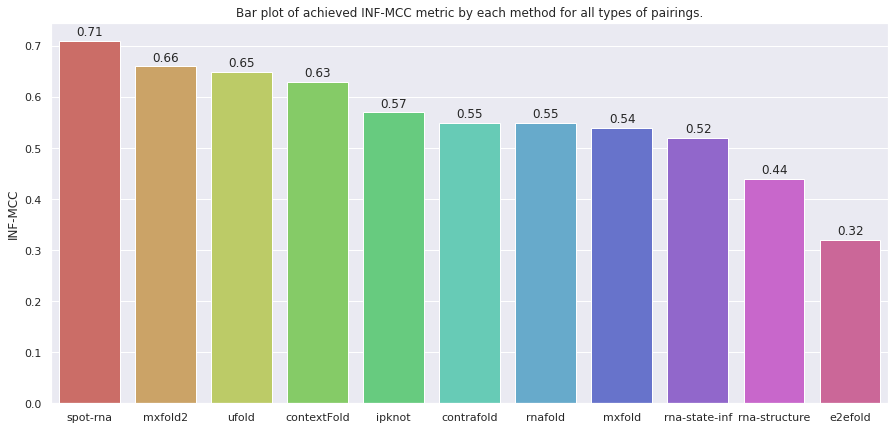

In [46]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10, 15)})
palette='hls'
ax = sns.barplot(x=df_means.index, y="INF-MCC", palette = palette, data=df_means)
ax.set(title="Bar plot of achieved INF-MCC metric by each method for all types of pairings.")

for i, v in enumerate(df_means['INF-MCC']):
    ax.text(i-0.17, v+0.01, str(v))


In [89]:
df_means['Method'] = df_means.index
print(len(df_means))
melt = pd.melt(df_means, id_vars='Method')
melt.head()

11


,Method,variable,value
0,spot-rna,PPV,0.61
1,mxfold2,PPV,0.54
2,ufold,PPV,0.53
3,contextFold,PPV,0.50
4,ipknot,PPV,0.46


[Text(0.5, 1.0, 'Bar plot of achieved INF-MCC metric by each method for all types of pairings.')]

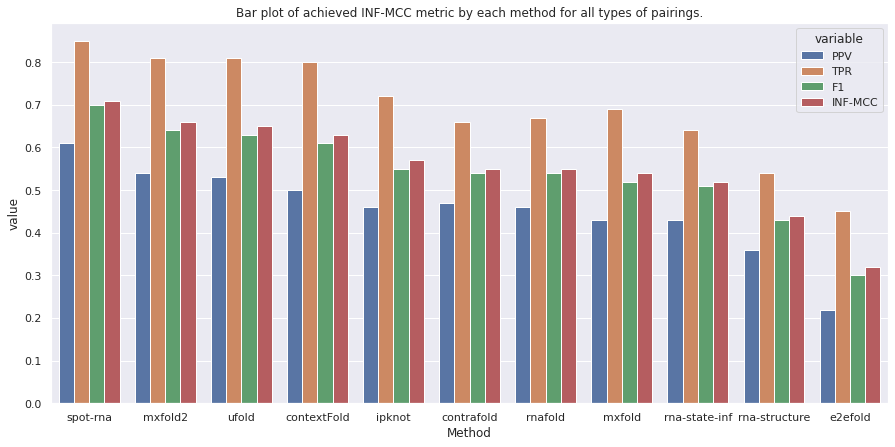

In [91]:
plt.figure(figsize=(15,7))
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10, 15)})
palette='deep'
ax = sns.barplot(x='Method', y='value', hue='variable', palette = palette, data=melt)
ax.set(title="Bar plot of achieved INF-MCC metric by each method for all types of pairings.")

In [67]:
df_means

,PPV,TPR,F1,INF-MCC
spot-rna,0.61,0.85,0.70,0.71
mxfold2,0.54,0.81,0.64,0.66
ufold,0.53,0.81,0.63,0.65
contextFold,0.50,0.80,0.61,0.63
ipknot,0.46,0.72,0.55,0.57
contrafold,0.47,0.66,0.54,0.55
rnafold,0.46,0.67,0.54,0.55
mxfold,0.43,0.69,0.52,0.54
rna-state-inf,0.43,0.64,0.51,0.52
rna-structure,0.36,0.54,0.43,0.44


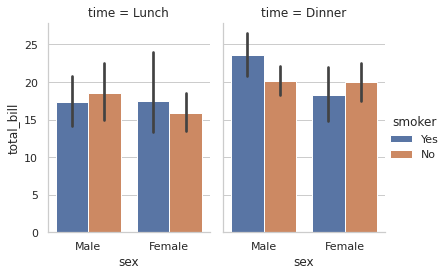

In [56]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
g = sns.catplot(x="sex", y="total_bill",
                hue="smoker", col="time",
                data=tips, kind="bar",
                height=4, aspect=.7);

In [53]:
tip

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


### Seaborn boxplot of means

[Text(0.5, 1.0, 'Box plot of achieved INF-MCC metric by each method for all types of pairings.')]

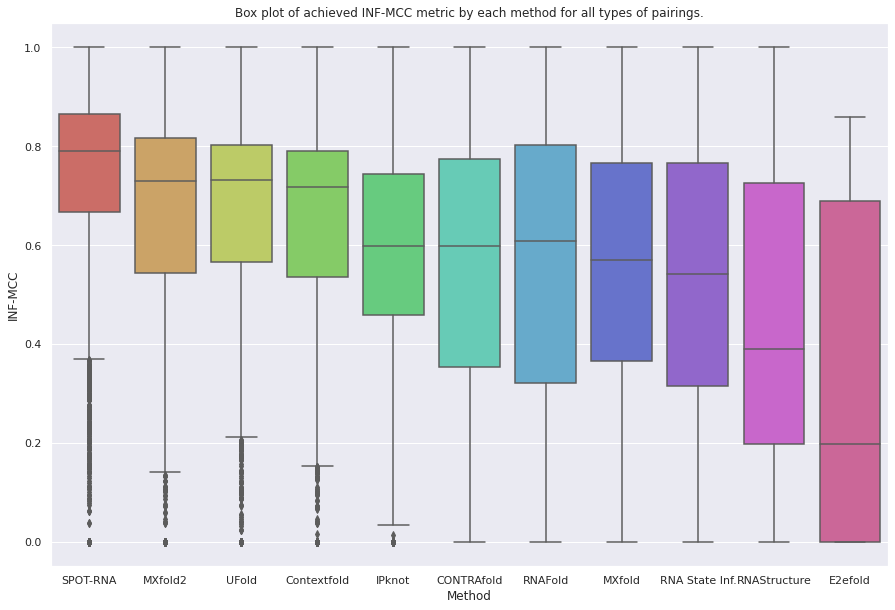

In [44]:
plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10, 15)})
ax = sns.boxplot(x="Method", y="INF-MCC", palette=palette, data=sns_df)
ax.set(title="Box plot of achieved INF-MCC metric by each method for all types of pairings.")

## Seaborn violin plot

Text(0, 0.5, 'Mean INF-MCC')

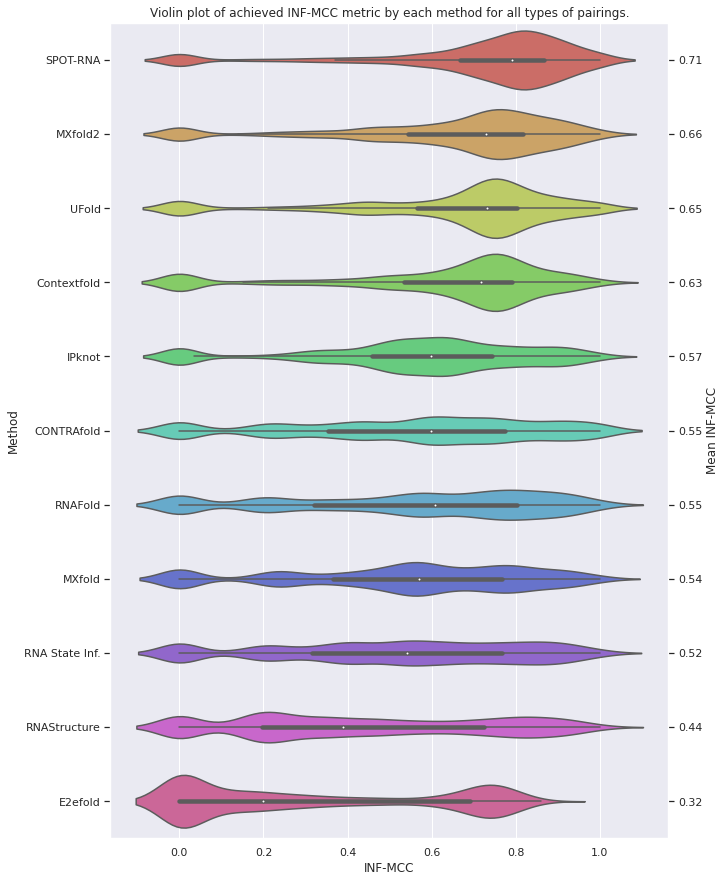

In [45]:
import seaborn as sns

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10, 15)})
palette='hls'

ax = sns.violinplot(x='INF-MCC', y='Method', inner="box", palette=palette, data=sns_df)
ax.set(title="Violin plot of achieved INF-MCC metric by each method for all types of pairings.")
axR = ax.twinx() 
axR.yaxis.grid(False)#, linestyle='', which='major', color='grey', alpha=.25)
pos = np.arange(len(ax.get_yticks()))
axR.set_yticks(pos)
axR.set_yticklabels(df_means['INF-MCC'])
axR.set_ylim(ax.get_ylim())
axR.set_ylabel("Mean INF-MCC")

# ax = sns.boxenplot(x='INF-MCC', y='Means', width=0.05, palette=palette, data=sns_df, ax=axR)
# ax.yaxis.tick_right()